<a href="https://colab.research.google.com/github/PiotMik/NumericalMethodsForSDEs/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (10, 5)

## Poisson process simulation

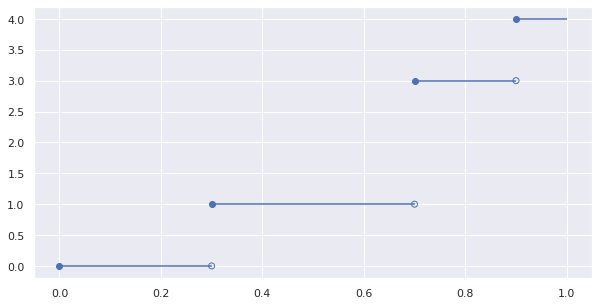

In [57]:
def plot_poisson(jump_moments, jump_sizes, horizon=None, simplified_plot = True):
  levels = np.array(jump_sizes).cumsum()
  jump_moments = np.array(jump_moments)

  if jump_moments[0] != 0.0:
    levels = np.concatenate([np.array([0]), levels])
    jump_moments = np.concatenate([np.array([0]), jump_moments])
  if horizon is not None and jump_moments[-1] != horizon:
    levels = np.concatenate([levels, np.array([levels[-1]])])
    jump_moments = np.concatenate([jump_moments, np.array([horizon])])
  
  df = pd.DataFrame.from_dict({'t': jump_moments,
                               'Nt': levels})
  if simplified_plot:  
    df.set_index('t', inplace=True)
    df.plot(drawstyle="steps-post")
  else:
    fig, ax = plt.subplots()
    for t_left, t_right, level in zip(df['t'][:-1], df['t'][1:], levels):
        ax.hlines(y=level, xmin=t_left, xmax=t_right, color='b')
    ax.scatter(x = df.t[:-1], y = df.Nt[:-1], color='b')
    ax.scatter(x = df.t[1:-1], y = df.Nt[:-2], facecolors='none', edgecolors='b')
  return df  

t = [0.3, 0.7, 0.9]
jump_sizes = [1, 2, 1]
_ = plot_poisson(jump_moments = t, jump_sizes = jump_sizes,
                 horizon=1, simplified_plot=False)

In [18]:
np.concatenate([np.array([0]), np.array(t)])

array([0. , 0.3, 0.7, 0.9])